# Notebook Contents
- Importing The Dependencies
- Loading The Data
- Preparing The Data
- Data Inspection
- Building The Siamese Network
- Training The Network
- Testing The Network

### `Importing The Dependencies`

In [1]:
# Operating system
import os

# PyTorch
from torch.utils.data import Dataset
import torch
import torchvision.datasets as dset
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# Random
import random

# Numpy
import numpy as np

# Image
from PIL import Image

# PIL
import PIL

# Matplotlib
import matplotlib.pyplot as plt

### `Loading The Data`

In [2]:
# Creating a dir
os.mkdir('data')

# Unzip the file into the new dir
!unzip -q archive.zip -d /content/data

# Creating faces dir in data
os.mkdir('/content/data/faces')

# Creating train and test dirs into faces
os.mkdir('/content/data/faces/train')
os.mkdir('/content/data/faces/test')

# Move s5,s6,s7 into testing and the others into training
os.chdir('/content/data')
!mv s5 s6 s7 faces/test

# Move all the remaining files to train
!mv s* faces/train

### `Preparing The Data`

In [3]:
# Create the dataset 
class DataSet(Dataset):

  # Init func
  def __init__(self,imagefolder,transform = None,invert = True):
    self.imagefolder = imagefolder
    self.transform = transform
    self.invert = invert

  # Get the len
  def __len__(self):
    return len(self.imagefolder.imgs)

  # Get an item
  def __getitem__(self,idx):

    # Image 0
    img0 = random.choice(self.imagefolder.imgs)

    # Make sure the images are same or not
    same = np.random.randint(0,1)
    if same:
      while True:
        img1 = random.choice(self.imagefolder.imgs)
        if img0[1] == img1[1]:
          break
    else:
      while True:
        img1 = random.choice(self.imagefolder.imgs)
        if img0[1] != img1[1]:
          break
    
    # Get the images
    img0_ = Image.open(img0[0])
    img1_ = Image.open(img1[0])

    # Convert images
    img0_ = img0_.convert('L')
    img1_ = img1_.convert('L')

    # Invert
    if self.invert:
      img0_ = PIL.ImageOps.invert(img0_)
      img1_ = PIL.ImageOps.invert(img1_)

    # Transform
    if self.transform:
      img0_ = self.transform(img0_)
      img1_ = self.transform(img1_)
    
    # The result
    return img0_,img1_,torch.from_numpy(np.array([int(img0[1] != img1[1])],dtype = np.float32))

# Saving parammeters
class Params():
  train_dir = '/content/data/faces/train'
  test_dir = '/content/data/faces/test'
  train_batch_size = 64
  train_epochs = 100

# Define the data root
datafolder = dset.ImageFolder(root = Params.train_dir)

# Define transforms
transform = transforms.Compose([transforms.ToTensor(),transforms.Resize((100,100))])

# Construct the dataset
dataset = DataSet(imagefolder = datafolder,transform = transform, invert = False)

### `Data Inspection`

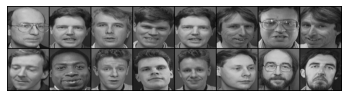

Labels =  1 1 1 1 1 1 1 1


In [4]:
# Data loader
data_loader = DataLoader(dataset = dataset,batch_size = 8,shuffle = True)

# Get a batch
data_batch = next(iter(data_loader))

# Concate the images
concated_imgs = torch.cat((data_batch[0],data_batch[1]),0)

# Plot a grid
def imshow(img,txt = None):
  # To numpy
  img = img.numpy()

  # check text
  if txt:
    plt.text(75,8,txt,style = 'italic',fontweight = 'bold',bbox = {'facecolor':'white','alpha':0.8,'pad':7})
  plt.imshow(np.transpose(img,(1,2,0)))
  plt.axis('off')
  plt.show()
imshow(torchvision.utils.make_grid(concated_imgs))
plt.show()

# The labels
labels = ''.join("%2d" % int(lab[0]) for lab in data_batch[2].numpy())
print(f'Labels = {labels}')

### `Building The Siamese Network`

In [ ]:
# Creating class
class SiameseNet(nn.Module):
  # The init function
  def __init__(self):
    super(SiameseNet,self).__init__()

    # CNN Net
    self.cnn = nn.Sequential(
        # Layer1
        nn.ReflectionPad2d(1),
        nn.Conv2d(1,4,kernel_size = 3),
        nn.ReLU(inplace = True),
        nn.BatchNorm2d(4),

        # Layer2
        nn.ReflectionPad2d(1),
        nn.Conv2d(4,8,kernel_size = 3),
        nn.ReLU(inplace = True),
        nn.BatchNorm2d(8),

        # Layer3
        nn.ReflectionPad2d(1),
        nn.Conv2d(8,8,kernel_size = 3),
        nn.ReLU(inplace = True),
        nn.BatchNorm2d(8)
    )

    # FC Net
    self.fc = nn.Sequential(
        
        # Layer
        nn.Linear(8*100*100,500),
        nn.ReLU(inplace = True),
        
        # Layer2
        nn.Linear(500,500),
        nn.ReLU(inplace = True),

        # Layer3
        nn.Linear(500,5),
    )
  
  # Forward once func 
  def forward_once(self,x):
    out = self.cnn(x)
    out = out.view(out.size()[0],-1)
    out = self.fc(out)
    return out
  
  # Forward func
  def forward(self,input1,input2):
    out1 = self.forward_once(input1)
    out2 = self.forward_once(input2)
    return out1,out2

In [ ]:
# The loss
class ContrastiveLoss(nn.Module):

  # The init func
  def __init__(self,margin = 2.0):
    super(ContrastiveLoss,self).__init__()
    self.margin = margin
  
  # The forward func
  def forward(self,out1,out2,label):
    euclidean_dist = F.pairwise_distance(out1,out2,keepdim = True)
    loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_dist,2) + (label) * torch.pow(torch.clamp(self.margin - euclidean_dist,min = 0.0),2))
    return loss_contrastive

In [ ]:
# Data loader
data_loader = DataLoader(dataset,batch_size = Params.train_batch_size,shuffle = True)

In [ ]:
# An object
net = SiameseNet().cuda()

# The loss
criterion = ContrastiveLoss()

# The optimizer
opt = optim.Adam(net.parameters(),lr = 0.000001)

### `Training The Network`

In [ ]:
# Required var
itr = 0
counter = []
loss_hist = []

# Iterating over the epochs
for epoch in range(Params.train_epochs):
  # Iterating over loaders
  for idx,data in enumerate(data_loader):
    img0,img1,label = data
    img0,img1,label = img0.cuda(),img1.cuda(),label.cuda()
    opt.zero_grad()
    out1,out2 = net(img0,img1)
    loss = criterion(out1,out2,label)
    loss.backward()
    opt.step()

    # Set the iterations
    if idx % 10 == 0:
      print(f'Epoch{epoch + 1} Current Loss = {loss.item():.5f}')
      loss_hist.append(loss.item())
      itr += 10
      counter.append(itr)

Epoch1 Current Loss = 3.29846
Epoch2 Current Loss = 2.74192
Epoch3 Current Loss = 2.33132
Epoch4 Current Loss = 1.92210
Epoch5 Current Loss = 1.44811
Epoch6 Current Loss = 0.84819
Epoch7 Current Loss = 0.76974
Epoch8 Current Loss = 0.43660
Epoch9 Current Loss = 0.40893
Epoch10 Current Loss = 0.34923
Epoch11 Current Loss = 0.39988
Epoch12 Current Loss = 0.22072
Epoch13 Current Loss = 0.14192
Epoch14 Current Loss = 0.22070
Epoch15 Current Loss = 0.21413
Epoch16 Current Loss = 0.26715
Epoch17 Current Loss = 0.24936
Epoch18 Current Loss = 0.21056
Epoch19 Current Loss = 0.13222
Epoch20 Current Loss = 0.17503
Epoch21 Current Loss = 0.13645
Epoch22 Current Loss = 0.07113
Epoch23 Current Loss = 0.13892
Epoch24 Current Loss = 0.11086
Epoch25 Current Loss = 0.11013
Epoch26 Current Loss = 0.07055
Epoch27 Current Loss = 0.07855
Epoch28 Current Loss = 0.05862
Epoch29 Current Loss = 0.02710
Epoch30 Current Loss = 0.07771
Epoch31 Current Loss = 0.07990
Epoch32 Current Loss = 0.10106
Epoch33 Current L

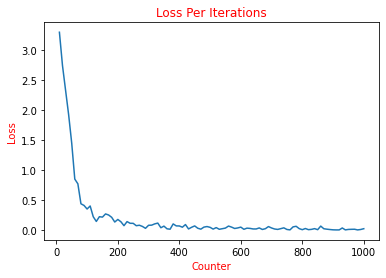

In [ ]:
# Plot the results
def plot_loss(cntr,loss):
  plt.plot(cntr,loss)
  plt.xlabel('Counter', c = 'r')
  plt.ylabel('Loss', c = 'r')
  plt.title('Loss Per Iterations', c = 'r')
  plt.show()

plot_loss(counter,loss_hist)

### `Testing The Network`

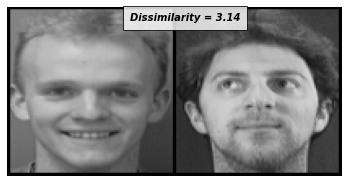

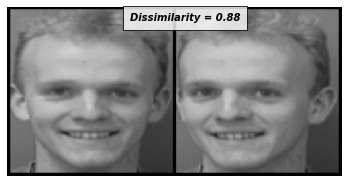

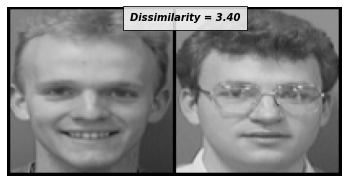

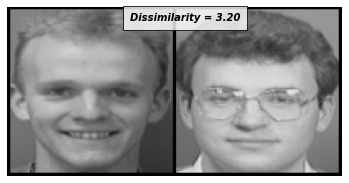

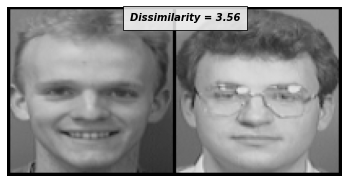

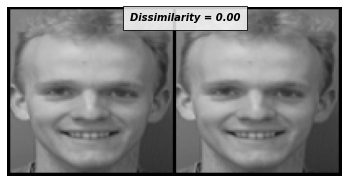

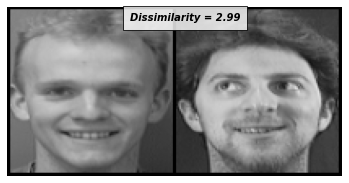

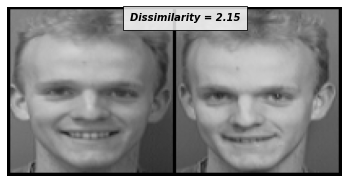

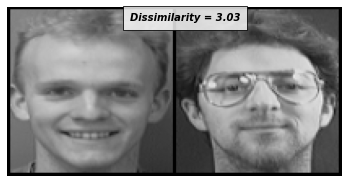

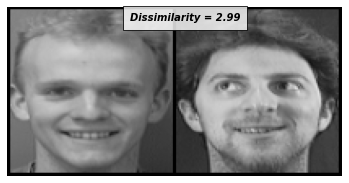

In [ ]:
# Test some samples
test_folder = dset.ImageFolder(root = Params.test_dir)
test_data = DataSet(test_folder,transform,False)
test_loader = DataLoader(test_data,1,True)
data_itr = iter(test_loader)
img0,_,_ = next(data_itr)
for i in range(10):
  _,img1,_ = next(data_itr)
  out1,out2 = net(Variable(img0).cuda(),Variable(img1).cuda())
  euc_dist = F.pairwise_distance(out1,out2)
  conc = torch.cat((img0,img1),0)
  imshow(torchvision.utils.make_grid(conc),f"Dissimilarity = {euc_dist.item():.2f}")